In [1]:
using Plots
using LinearAlgebra, SparseArrays
using DelimitedFiles
using Gurobi, JuMP
using Random
Random.seed!(1234);  # determinism

In [2]:
# Read data
data = readdlm("zacharys-KC.txt")
n = 34
A = sparse(convert(Vector{Int64}, data[:,1]),
           convert(Vector{Int64}, data[:,2]), 1, n, n)
labels = zeros(n)
labels[[1,2,3,4,5,6,7,8,11,12,13,14,17,18,20,22]] .= 1
As = max.(A, A');
Ad = Matrix(A);

In [3]:
k = 2

function update_R(L::Array{Float64,2})
    model = Model(solver=GurobiSolver(Presolve=0))
    @variable(model, R[1:k,1:n])
    @objective(model, Min, sum((Ad - L * R).^2))  # Frobenius norm
    @constraint(model, R .>= 0)                  # nonnegativity
    solve(model)
    return getvalue(R)
end

function update_L(R::Array{Float64,2})
    model = Model(solver=GurobiSolver(Presolve=0))
    @variable(model, L[1:n, 1:k])
    @objective(model, Min, sum((Ad - L * R).^2))  # Frobenius norm
    @constraint(model, L .>= 0)                  # nonnegativity
    @constraint(model, sum(L, dims=2) .== 1)     # rows sum to 1
    solve(model)
    return getvalue(L)    
end

L, R = rand(n, 2), rand(2, n)
for i = 1:50
    L = update_L(R)
    R = update_R(L)
end

Academic license - for non-commercial use only
Optimize a model with 102 rows, 68 columns and 136 nonzeros
Model has 102 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+01]
  QObjective range [2e+01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 102
 AA' NZ     : 1.700e+02
 Factor NZ  : 3.400e+02
 Factor Ops : 1.020e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.47569317e+02 -3.15027178e+02  7.77e-15 1.52e+01  1.00e+06     0s
   1   8.43687917e+05 -8.98055374e+05  5.77e+01 8.90e-01  8.08e+04     0s
   2   3.06105163e+02 -7.62155107e+04  1.55e-01 6.86e-03  1.76e+03     0s
   3   2.81283092e+02 -1.05303874e+04  4.68e-07 9.40e-08  1.59e+02     0s
   4   2.80005846e+02 -6.41691891e+01  7.91e-08 7.93e

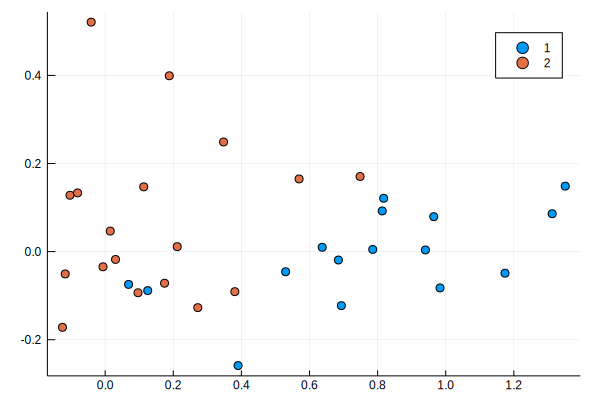

In [4]:
inds1 = findall(labels .== 1)
inds2 = findall(labels .== 0)
scatter( vec(R[1,inds1]) + randn(length(inds1)) * 1e-1, 
         vec(R[2,inds1]) + randn(length(inds1)) * 1e-1, label="1")
scatter!(vec(R[1,inds2]) + randn(length(inds2)) * 1e-1, 
         vec(R[2,inds2]) + randn(length(inds2)) * 1e-1, label="2")